**Introduction**

This codelab walks you through how to use different Search and Store types for indexing embeddings for nearest neighbor lookups, both exact lookup and approximate lookups.
The Indexer uses two components to handle the indexing:


1.   Search: The component that given an embedding looks up k-nearest-neighbors of it
2.   Store: stores and retrievs the metadata associated with a given embedding



The package currently supports the following NN algorithms (Search component):

*   LinearSearch
*   nmslib
*   Faiss

It supports the following Stores:

*   MemoryStore: For small datasets that fit in the memory
*   CachedStore: For medium size datasets that would fit in the memory and disk of the machine
*   RedisStore: For larger datasets that would require a server to store and retrieve the metadata










<a target="_blank" href="https://colab.research.google.com/github/tensorflow/similarity/blob/development/examples/indexing_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>

# Setup requirements

In [1]:
#@title install git repo's indexing branch
!git clone https://github.com/tensorflow/similarity.git && cd similarity && git checkout dev_cleanup && pip install .[dev] && cd ..


Cloning into 'similarity'...
remote: Enumerating objects: 7352, done.
remote: Counting objects: 100% (1558/1558), done.
remote: Compressing objects: 100% (702/702), done.
remote: Total 7352 (delta 887), reused 933 (delta 852), pack-reused 5794
Receiving objects: 100% (7352/7352), 180.34 MiB | 10.22 MiB/s, done.
Resolving deltas: 100% (4618/4618), done.
Branch 'dev_cleanup' set up to track remote branch 'dev_cleanup' from 'origin'.
Switched to a new branch 'dev_cleanup'
Processing /content/similarity
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
#@title check if the package is installed successfully
!pip list | grep tensorflow

tensorflow                       2.12.0
tensorflow-datasets              4.9.2
tensorflow-estimator             2.12.0
tensorflow-gcs-config            2.12.0
tensorflow-hub                   0.14.0
tensorflow-io-gcs-filesystem     0.32.0
tensorflow-metadata              1.13.1
tensorflow-probability           0.20.1
tensorflow-similarity            0.18.0.dev5


In [3]:
#@title install redis
!apt install redis-server
!pip install redis


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libjemalloc2 liblua5.1-0 liblzf1 lua-bitop lua-cjson redis-tools
Suggested packages:
  ruby-redis
The following NEW packages will be installed:
  libjemalloc2 liblua5.1-0 liblzf1 lua-bitop lua-cjson redis-server
  redis-tools
0 upgraded, 7 newly installed, 0 to remove and 16 not upgraded.
Need to get 1,273 kB of archives.
After this operation, 5,725 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libjemalloc2 amd64 5.2.1-4ubuntu1 [240 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 liblua5.1-0 amd64 5.1.5-8.1build4 [99.9 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 liblzf1 amd64 3.6-3 [7,444 B]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 lua-bitop amd64 1.0.2-5 [6,680 B]
Get:5 http://archive.ubuntu.com/ubuntu jammy/universe amd64 lua

In [4]:
#@title run redis in the background
!redis-server --daemonize yes

In [5]:
#@title test redis running
import redis
client = redis.Redis(host = 'localhost', port=6379)

client.ping()

True

In [6]:
#@title imports
import gc
import os

import numpy as np
from matplotlib import pyplot as plt
from tabulate import tabulate
import tensorflow as tf
import tensorflow_similarity as tfsim  # main package
import imp

imp.reload(tfsim)

# INFO messages are not printed.
# This must be run before loading other modules.
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [7]:
#@title allow gpu memory to grow
tfsim.utils.tf_cap_memory()


In [8]:
#@title Clear out any old model state.
gc.collect()
tf.keras.backend.clear_session()
print("TensorFlow:", tf.__version__)
print("TensorFlow Similarity", tfsim.__version__)

TensorFlow: 2.12.0
TensorFlow Similarity 0.18.0.dev5


In [9]:
#@title check if GPUs available
tf.config.list_physical_devices('GPU')

[]

# prepare the data and the model

In [10]:
#@title load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [11]:
#@title the sampler
CLASSES = [2, 3, 1, 7, 9, 6, 8, 5, 0, 4]
NUM_CLASSES = 6  # @param {type: "slider", min: 1, max: 10}
CLASSES_PER_BATCH = NUM_CLASSES
EXAMPLES_PER_CLASS = 10  # @param {type:"integer"}
STEPS_PER_EPOCH = 1000  # @param {type:"integer"}

sampler = tfsim.samplers.MultiShotMemorySampler(
    x_train,
    y_train,
    classes_per_batch=CLASSES_PER_BATCH,
    examples_per_class_per_batch=EXAMPLES_PER_CLASS,
    class_list=CLASSES[:NUM_CLASSES],  # Only use the first 6 classes for training.
    steps_per_epoch=STEPS_PER_EPOCH,
)


The initial batch size is 60 (6 classes * 10 examples per class) with 0 augmentations


filtering examples:   0%|          | 0/60000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/6 [00:00<?, ?it/s]

gather examples:   0%|          | 0/36963 [00:00<?, ?it/s]

indexing classes:   0%|          | 0/36963 [00:00<?, ?it/s]

In [12]:
#@title the model
def get_model():
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.experimental.preprocessing.Rescaling(1 / 255)(inputs)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(32, 3, activation="relu")(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Conv2D(64, 3, activation="relu")(x)
    x = tf.keras.layers.Flatten()(x)
    # smaller embeddings will have faster lookup times while a larger embedding will improve the accuracy up to a point.
    outputs = tfsim.layers.MetricEmbedding(64)(x)
    return tfsim.models.SimilarityModel(inputs, outputs)


model = get_model()
model.summary()

Model: "similarity_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                  

# Use FaissSearch and CachedStore

Now that we have created the model, we need to load the Store and Search components and pass them to compile to be integrated into the model for indexing.

In [13]:
#@title load Store and Search components and configure them
from tensorflow_similarity.stores import CachedStore, RedisStore
from tensorflow_similarity.search import LinearSearch
from tensorflow_similarity.search import FaissSearch
distance = "cosine"  # @param ["cosine", "L2", "L1"]{allow-input: false}
loss = tfsim.losses.MultiSimilarityLoss(distance=distance)
store = CachedStore()
search = FaissSearch(distance, 64)

In [14]:
#@title compile the model
LR = 0.000005  # @param {type:"number"}
model.compile(optimizer=tf.keras.optimizers.Adam(LR), loss=loss, kv_store=store, search=search)

Distance metric automatically set to cosine use the distance arg to override.


1000/1000 [==============================] - 219s 211ms/step - loss: 0.8318 - val_loss: 0.4240
Warmup complete


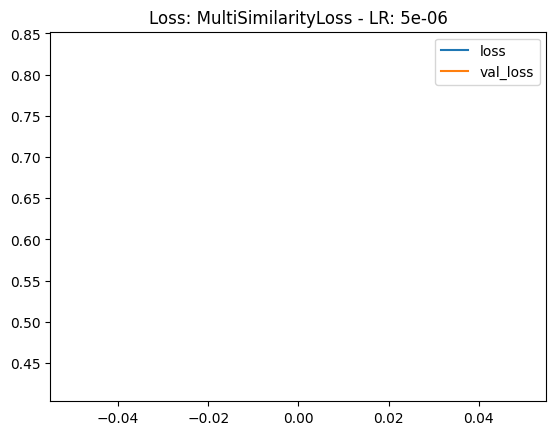

In [15]:
#@title training
EPOCHS = 1  # @param {type:"integer"}
history = model.fit(sampler, epochs=EPOCHS, validation_data=(x_test, y_test))
# expect loss: 0.14 / val_loss: 0.33
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.legend(["loss", "val_loss"])
plt.title(f"Loss: {loss.name} - LR: {LR}")
plt.show()

In [16]:
#@title make index
x_index, y_index = tfsim.samplers.select_examples(x_train, y_train, CLASSES, 2048)
model.reset_index()
model.index(x_index, y_index, data=x_index)

filtering examples:   0%|          | 0/60000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/20480 [00:00<?, ?it/s]

[Indexing 20480 points]
|-Computing embeddings
640/640 [==============================] - 17s 26ms/step
|-Storing data points in key value store
building Faiss index


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 250ms/step

Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

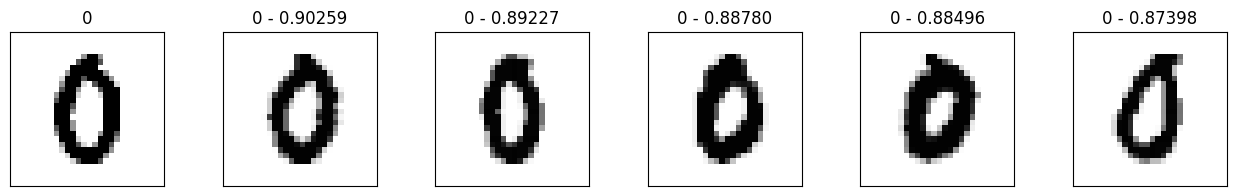

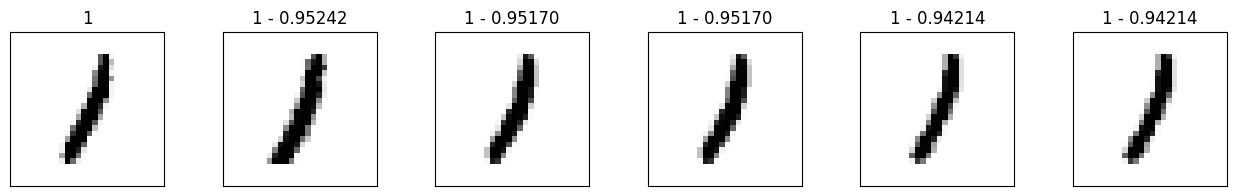

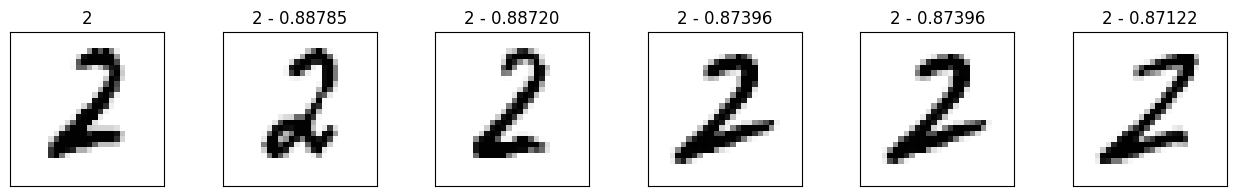

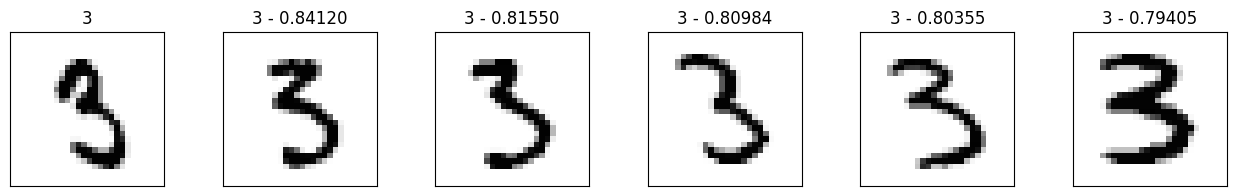

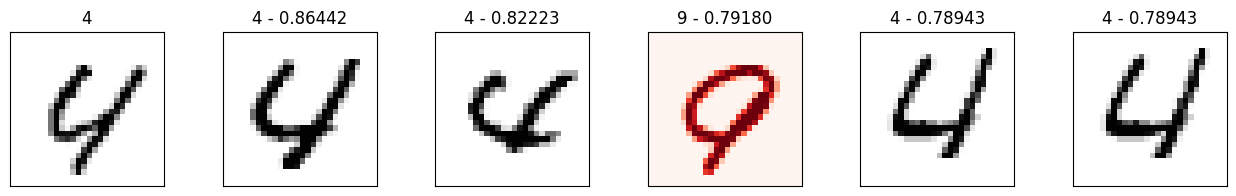

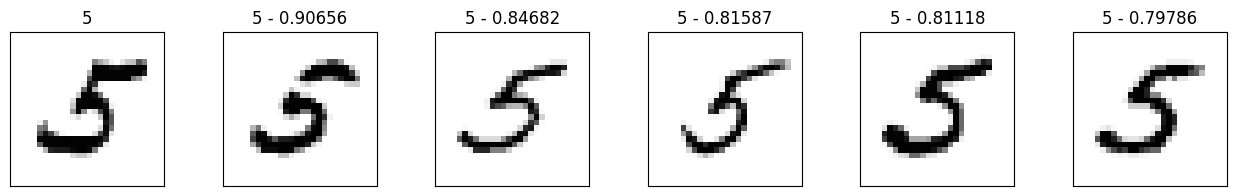

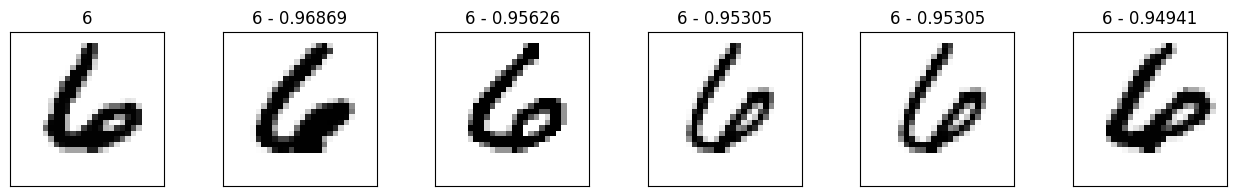

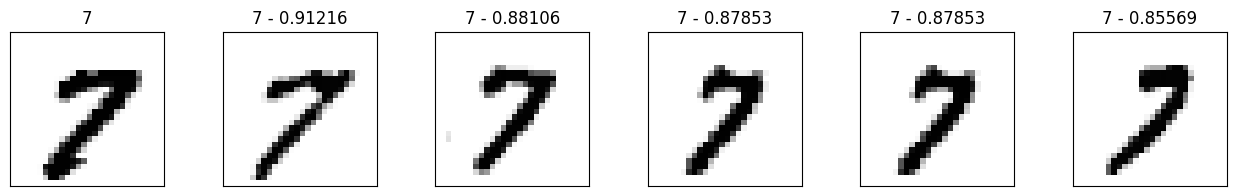

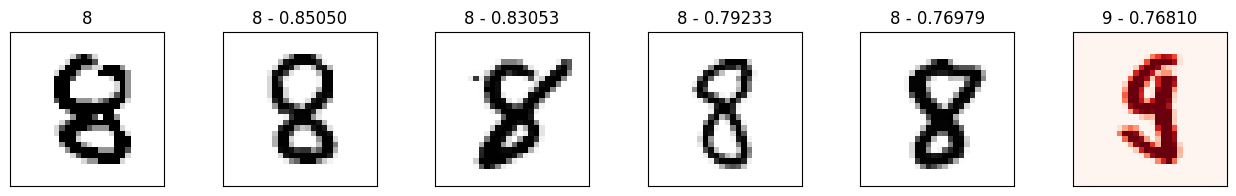

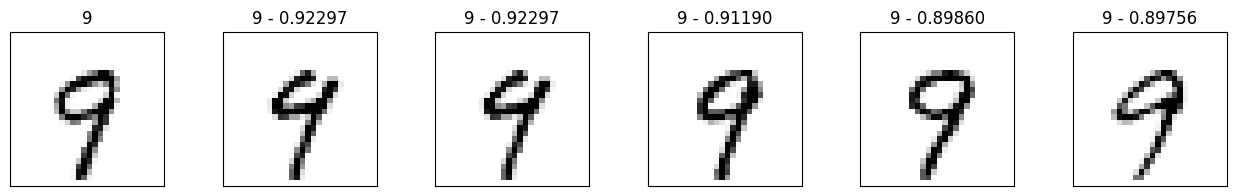

In [17]:
#@title NN lookup results
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")

In [18]:
model.index_summary()

[Info]
------------------  -----------
distance            cosine
key value store     CachedStore
search algorithm    FaissSearch
evaluator           memory
index size          20480
calibrated          False
calibration_metric  f1
embedding_output
------------------  -----------



[Performance]
-----------  -----------
num lookups  10
min           0.00323603
max           0.00323603
avg           0.00323603
median        0.00323603
stddev        0
-----------  -----------


In [19]:
#@title save the model and the index
save_path = "models/hello_world"  # @param {type:"string"}
model.save(save_path, save_index=True)

# Use LinearSearch and RedisStore

In [20]:
#@title reload the model
reloaded_model = tf.keras.models.load_model(
    save_path,
    custom_objects={"SimilarityModel": tfsim.models.SimilarityModel},
)
# reload the index
reloaded_model.load_index(save_path)

Distance metric automatically set to cosine use the distance arg to override.
Loading index data
Loading search index


In [21]:
#@title check the index is back
reloaded_model.index_summary()

[Info]
------------------  -----------
distance            cosine
key value store     CachedStore
search algorithm    FaissSearch
evaluator           memory
index size          20480
calibrated          False
calibration_metric  f1
embedding_output
------------------  -----------



[Performance]
-----------  -
num lookups  0
min          0
max          0
avg          0
median       0
stddev       0
-----------  -


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step

Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

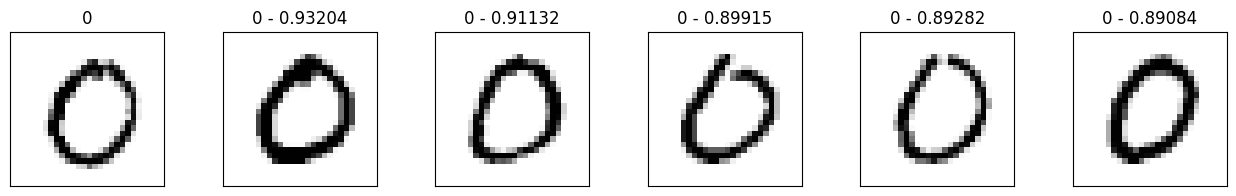

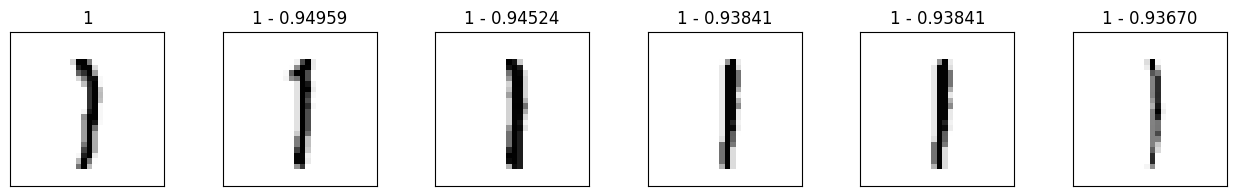

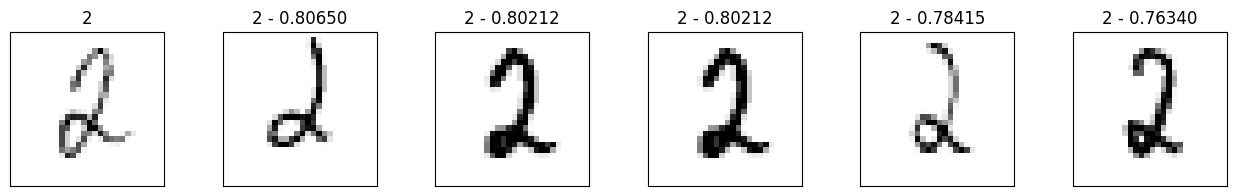

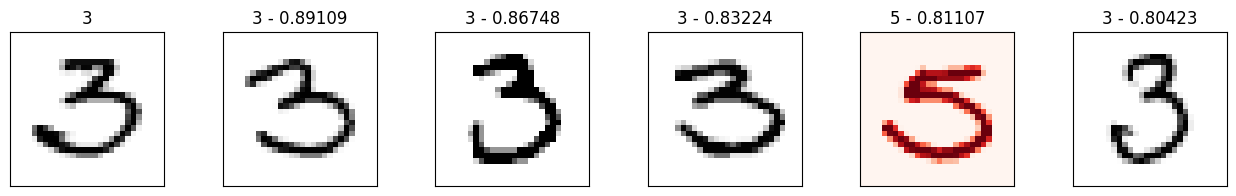

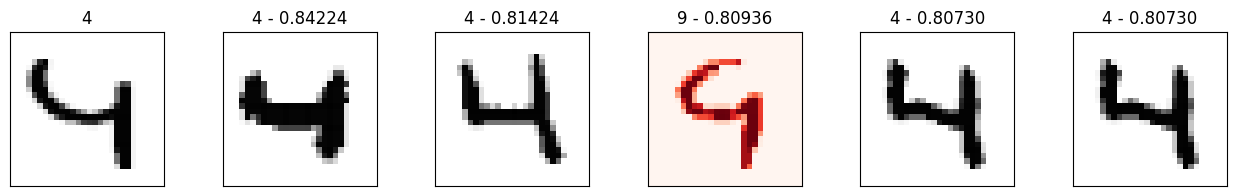

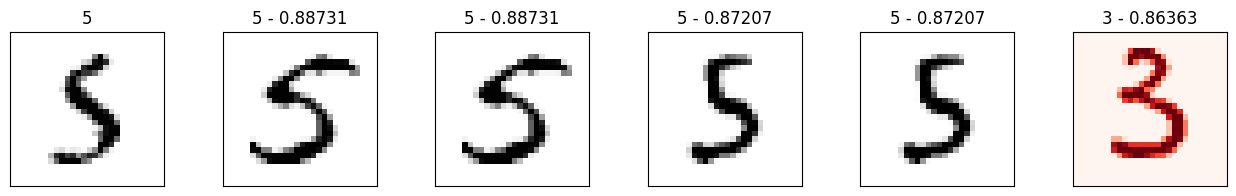

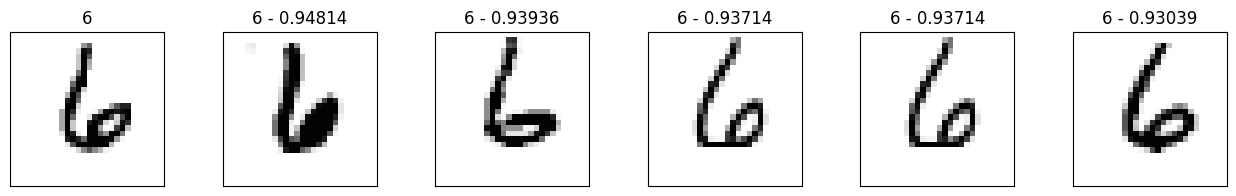

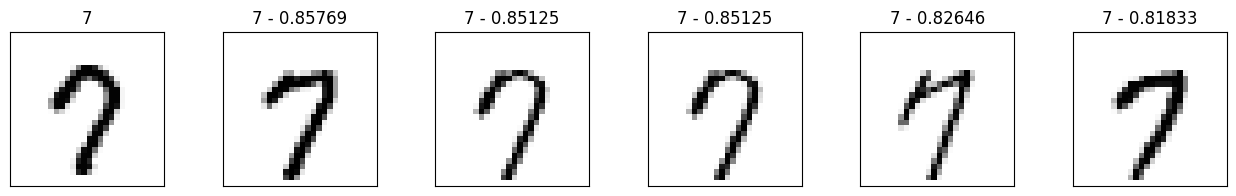

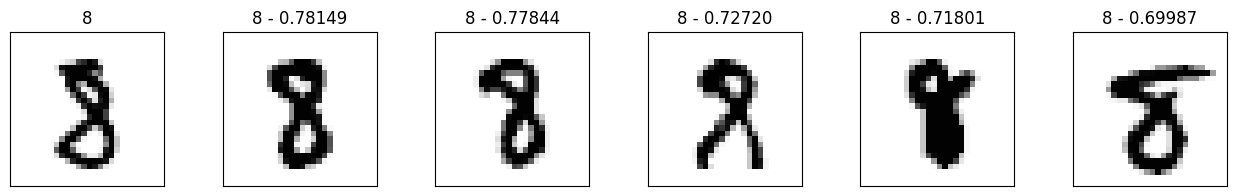

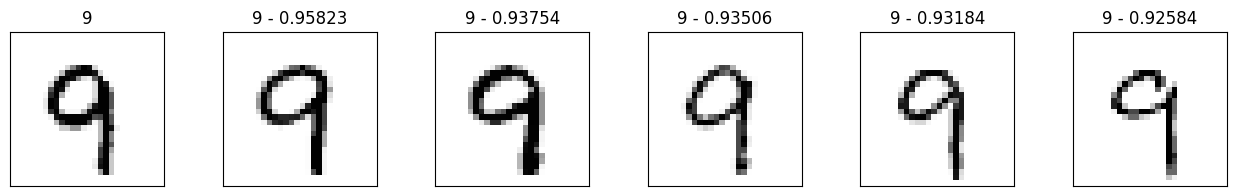

In [22]:
#@title re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, CLASSES, 1)

# lookup the nearest neighbors
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")

In [23]:
model._index.search = LinearSearch('cosine', 64)
model._index.kv_store = RedisStore()

In [24]:
model.reset_index()
model.index(x_index, y_index, data=x_index)

[Indexing 20480 points]
|-Computing embeddings
640/640 [==============================] - 17s 26ms/step
|-Storing data points in key value store


filtering examples:   0%|          | 0/10000 [00:00<?, ?it/s]

selecting classes:   0%|          | 0/10 [00:00<?, ?it/s]

gather examples:   0%|          | 0/10 [00:00<?, ?it/s]

1/1 [==============================] - 0s 74ms/step

Performing NN search



Building NN list:   0%|          | 0/10 [00:00<?, ?it/s]

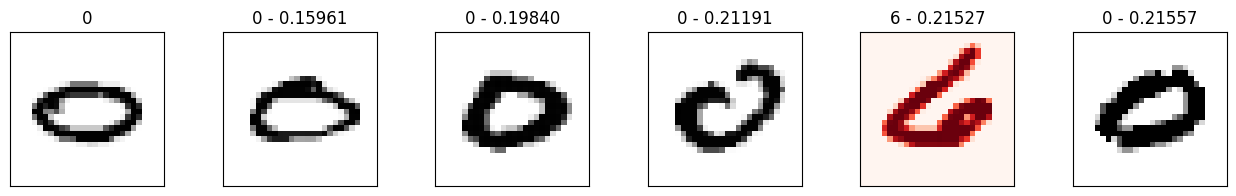

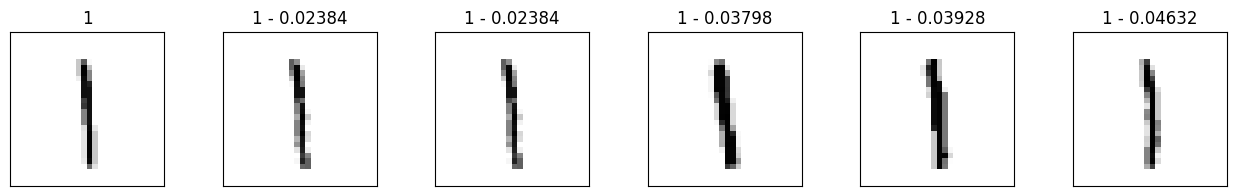

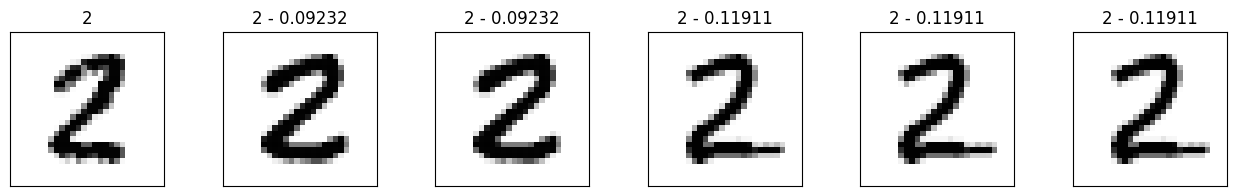

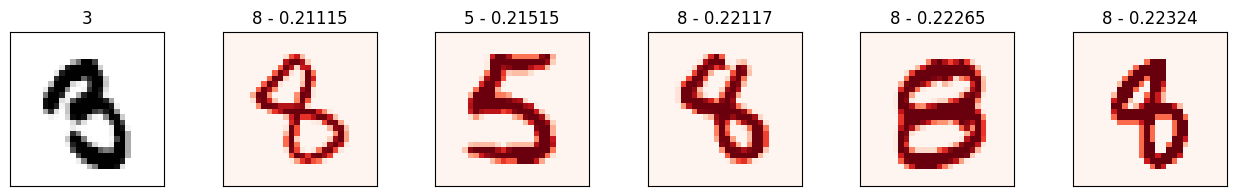

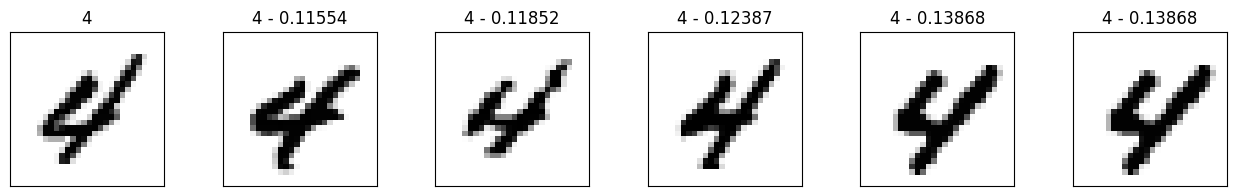

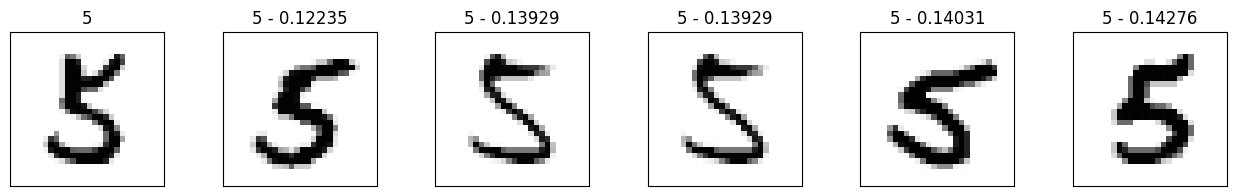

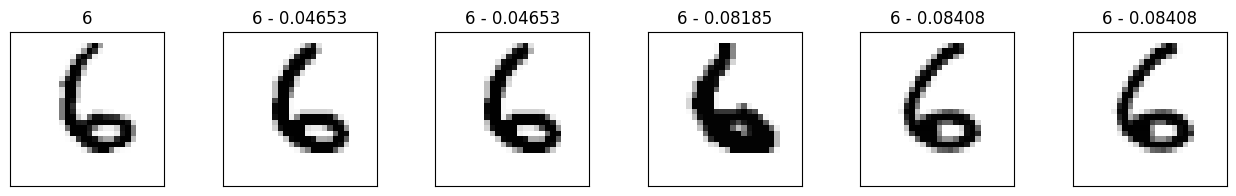

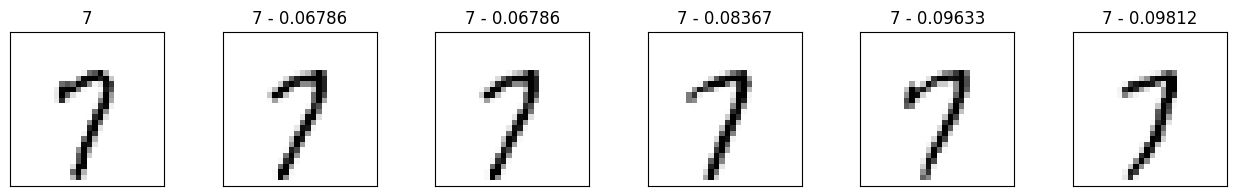

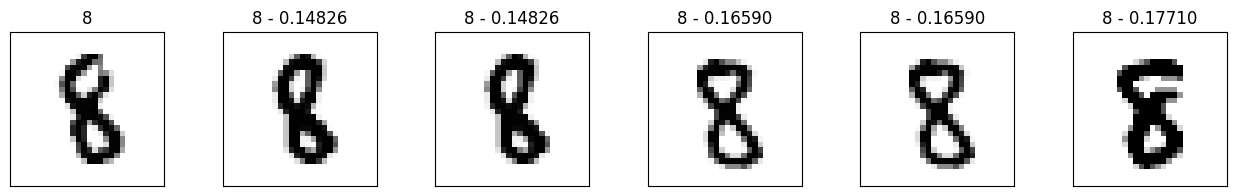

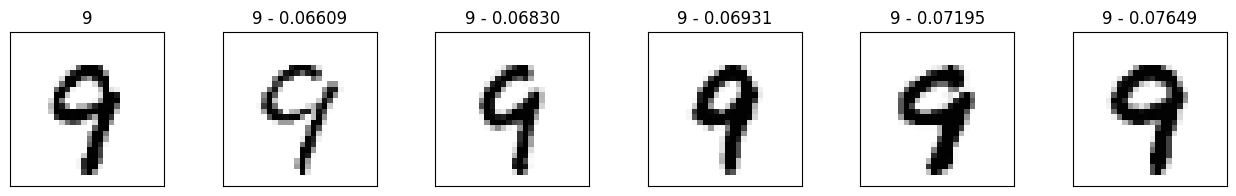

In [25]:
#@title NN lookup results
# re-run to test on other examples
num_neighbors = 5

# select
x_display, y_display = tfsim.samplers.select_examples(x_test, y_test, CLASSES, 1)

# lookup nearest neighbors in the index
nns = model.lookup(x_display, k=num_neighbors)

# display
for idx in np.argsort(y_display):
    tfsim.visualization.viz_neigbors_imgs(x_display[idx], y_display[idx], nns[idx], fig_size=(16, 2), cmap="Greys")